In [24]:
import scipy as scp
import numpy as np
import time
import datetime
#from datetime import timedelta
import matplotlib.pyplot as plt

print("hello world")

hello world


In [25]:
def getTime(mode):
    global start_time0, start_time, end_time0, end_time
    match mode:
        case 'integrateStart':
            start_time0 = time.time()
            start_time = datetime.datetime.fromtimestamp(start_time0)
            return start_time
        case 'integrateEnd':
            end_time0 = time.time()
            end_time = datetime.datetime.fromtimestamp(end_time0)
            return end_time
        case 'current':
            current_time0 = time.time()
            current_time = datetime.datetime.fromtimestamp(current_time0)
            return current_time0, current_time
def printAlligned(message, variable, unit, msgspaces=20, varspaces=30):
    output = print("{:{msgspace}s}= {:{varspace}s} {}".format(message, str(variable), unit, msgspace=msgspaces, varspace=varspaces))
    return output
def debug(level='partial'):
    match level:
        case 'partial':
            print('   DEBUG LEVEL PARTIAL')
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'full':
            print('   DEBUG LEVEL FULL')
            print("List of globals:")
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'constants':
            print('   DEBUG LEVEL CONSTANTS')
            localT = getTime('current')[1]
            printAlligned('Current time', localT, '')
        case 'start':
            print('   DEBUG LEVEL START')
            localT = getTime('integrateStart')
            printAlligned('Start time', localT, 'seconds', msgspaces=15)
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'end':
            print('   DEBUG LEVEL END')
            end_time = time.time()
            printAlligned('end_time',end_time, 'seconds', msgspaces=15)
            printAlligned('Wall runtime',end_time-start_time, msgspaces=15)
        case 'none':
            return None

def initialize(mode,inSpos=[0,0],inSvel=[0,0],startdebugmode='start'): 
    # Constants
    match mode:
        case 'constants':
            global GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal
            GravConst = 6.6726e-11
            dEM = 3.844e8                                     #Earth-Moon separation
            mE = 5.9742e24                                  #Earth Mass
            mM = 7.35e22                                    #Moon mass
            mT = mE + mM                                    #Barycentre mass
            rE = dEM*mM/mT                                    #Barycentre-Earth separation
            rM = dEM*mE/mT                                    #Barycentre-Moon separation
            PeriodEM = np.sqrt(4 * np.pi**2 * dEM**3 / GravConst / mT)    #Orbital period
            l2Original = rM + dEM*(mM/3/mE)**(1/3)
            l2VelOriginal = 2*np.pi * l2Original / PeriodEM
            drOriginal = dEM*(mM/3/mE)**(1/3)
            return None
        case 'inputs':
            global iniSpos, iniSvel
            iniSpos = np.array(inSpos)
            iniSvel = np.array(inSvel)
            debug(startdebugmode)
            return None
    return 'FAILED TO INITIALIZE'
##initial velocity ???
initialize('constants')


'''unused debug
print(start_time)
printAlligned('S position',Spos)
print("{:20s}= {}".format('S position',Spos))
print("S velocity     = {}".format(Svel))
print("S acceleration = {}".format(Sacc))
print("P = {}".format(P))
print("HR P = {}".format(timedelta(seconds = P)))
'''

def calcEpos(time, loc_rE=rE):
    output = np.array([-loc_rE*np.cos(2*np.pi * time/PeriodEM),-loc_rE*np.sin(2*np.pi * time/PeriodEM)])
    return output
def calcMpos(time, loc_rM=rM):
    output = np.array([loc_rM*np.cos(2*np.pi * time/PeriodEM),loc_rM*np.sin(2*np.pi * time/PeriodEM)])
    return output
def d2t_r(time, x, y):
    loc_mE = mE
    loc_mM = mM
    Epos = calcEpos(time)
    Mpos = calcMpos(time)
    dE = np.sqrt((x - Epos[0])**2 + (y - Epos[1])**2)
    dM = np.sqrt((x - Mpos[0])**2 + (y - Mpos[1])**2)
    x2 = -GravConst*loc_mE*(x - Epos[0])/dE**3 - GravConst*loc_mM*(x - Mpos[0])/dM**3
    y2 = -GravConst*loc_mE*(y - Epos[1])/dE**3 - GravConst*loc_mM*(y - Mpos[1])/dM**3
    Sacc = np.array([x2,y2])
    return Sacc

#print(2*np.pi*rM/PeriodEM)

In [26]:
def TaylorODEsolve3BP(mode, t_0, t_f, dt, limits=[0,0], progress=True):
    match mode:
        case 'solve':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                Sacc = d2t_r(t, *Spos)
                Spos = Spos + dt * Svel + Sacc * dt**2 / 2
                Svel = Svel + dt * Sacc
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)
            errorVector = SposList[-1] - SposList[0]
            errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)
            print('error vector:   {} m'.format(errorVector))
            print('error distance: {} m'.format(errorDist))

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList
        case 'limits':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                '''#Progress bar, not used
                if i% (int(steps/10)) == 0:
                    n = round(i / steps, 2) * 100
                    printAlligned('{}%'.format(n), Spos,'m')
                    printAlligned('{}%'.format(n), Svel,'m s^-1')
                '''
                
                Sacc = d2t_r(t, *Spos)
                Spos = Spos + dt * Svel + Sacc * dt**2 / 2
                Svel = Svel + dt * Sacc
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)

                Sdist = np.sqrt(Spos[0]**2 + Spos[1]**2)
                if Sdist < limits[0]:
                    move = 1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i
                if Sdist > limits[1]:
                    move = -1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i

                
            errorVector = SposList[-1] - SposList[0]
            errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)
            print('error vector:   {} m'.format(errorVector))
            print('error distance: {} m'.format(errorDist))

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            move = 0
            return SposList, MposList, EposList, tList, move, steps


def RK4ODEsolve3BP(mode, t_0, t_f, dt, limits=[0,0], progress=True): #t_0: time initial [seconds], t_f: time final [seconds], dt: time step
    match mode:
        case 'solve':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                w0 = d2t_r(t, *Spos)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, *u1)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, *u2)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, *u3)
                
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)
            errorVector = SposList[-1] - SposList[0]
            errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)
            print('error vector:   {} m'.format(errorVector))
            print('error distance: {} m'.format(errorDist))

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList
        case 'limits':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                w0 = d2t_r(t, *Spos)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, *u1)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, *u2)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, *u3)
                
                '''#progress bar, not in use
                if i% (int(steps/10)) == 0:
                    n = round(i / steps, 2) * 100
                    printAlligned('{}%'.format(n), Spos,'m')
                    printAlligned('{}%'.format(n), Svel,'m s^-1')
                '''
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                Sdist = np.sqrt(Spos[0]**2 + Spos[1]**2)
                
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)
                if Sdist < limits[0]:
                    move = 1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i
                if Sdist > limits[1]:
                    move = -1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i
            errorVector = SposList[-1] - SposList[0]
            errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)
            print('error vector:   {} m'.format(errorVector))
            print('error distance: {} m'.format(errorDist))

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            move = 0
            return SposList, MposList, EposList, tList, move, steps


def plot(data=None,label='',mode='plot', plotLims=[-5e8,5e8,-5e8,5e8]):
    global ax
    match mode:
        case 'plot':
            ax.plot(*data, label=label)
        case 'axes':
            ax = plt.figure().add_subplot()
            plotLims = ax.axis(plotLims)
            ax.set_aspect('equal',adjustable='box')
            print('plot limits:{}'.format(plotLims))
            plt.axhline(0, color='black')
            plt.axvline(0, color='black')
        case 'show':
            ax.legend()
            plt.show()

def findFFactor(mode, fGuess, dPlaces, tolerance = 1e6, t_f = PeriodEM):
    fGuessStr = str(fGuess)
    print('guess: {}'.format('.' in fGuessStr))
    if ('.' in fGuessStr):
        dPlace = len(fGuessStr.split('.')[1])
    else:
        dPlace = 0
    f = fGuess
    fo = f
    #find length of decimal part
    digit = 0
    n = 1 #factor finding iteration number
    flist = []
    flist.append(f)
    pointslist = []
    match mode:
        case 'RK4':
            while dPlace <= dPlaces:
                dr = drOriginal *f
                l2 = rM + dr
                l2Vel = 2*np.pi * l2 / PeriodEM
                limits = [l2 - tolerance, l2 + tolerance]
                initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
                out = RK4ODEsolve3BP('limits', 0, t_f, 100, limits= limits) #solve in limit mode
                
                move = out[4]
                steps = out[5]
                if move == 1:
                    digit+=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}'.format('move:', str(move), 'steps:',steps))
                elif move == -1:
                    digit-=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    dPlace+=1
                    digit = 0
                    fo = f
                elif move ==0:
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    break
                else:
                    print('ERROR')
                    break
                flist.append(f)
                n+=1
        case 'Taylor':
            while dPlace <= dPlaces:
                dr = drOriginal *f
                l2 = rM + dr
                l2Vel = 2*np.pi * l2 / PeriodEM
                limits = [l2 - tolerance, l2 + tolerance]
                initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
                out = TaylorODEsolve3BP('limits', 0, t_f, 10, limits= limits) #solve in limit mode
                pointslist = [out[i] for i in range(3)]
                move = out[4]
                steps = out[5]
                if move == 1:
                    digit+=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}'.format('move:', str(move), 'steps:',steps))
                elif move == -1:
                    digit-=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    dPlace+=1
                    digit = 0
                    fo = f
                elif move ==0:
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    break
                else:
                    print('ERROR')
                    break
                flist.append(f)
                n+=1
    dr = drOriginal *f
    l2 = rM + dr
    l2Vel = 2*np.pi * l2 / PeriodEM
    limits = [l2 - tolerance, l2 + tolerance]
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
    out = RK4ODEsolve3BP('limits', 0, t_f, 100, limits= limits)
    pointslist = [out[i] for i in range(4)]
    print('f={} in {} steps'.format(f,n))
    return f, n, flist, pointslist

   FULL SOLVE
Start time:         0s   End time:         2357286.0s   Taylor timestep      10s   RK4 timestep        100s
error vector:   [ -549.3580808  -4364.47395163] m
error distance: 4398.912044520941 m
l2o: 441257093.7838804 m, l2: 444247850.6845985 m, dro: 61528853.295760974 m, dr: 64519610.196479075 m
plot limits:(-500000000.0, 500000000.0, -500000000.0, 500000000.0)


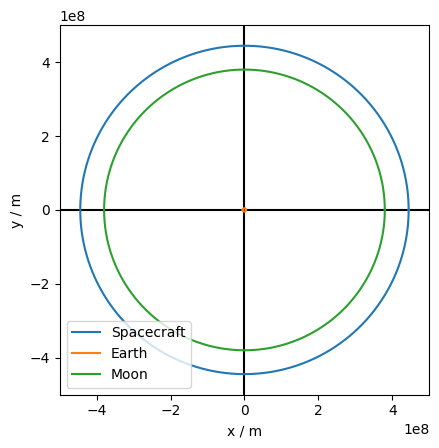

plot limits:(-100000000.0, 100000000.0, -100000000.0, 100000000.0)


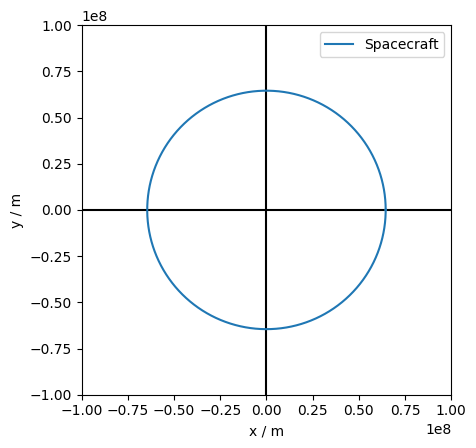

error vector:   [  -2406.80340028 -100288.67613927] m
error distance: 100317.55212511552 m
l2o: 441257093.7838804 m, l2: 444248356.26718605 m, dro: 61528853.295760974 m, dr: 64520115.77906661 m
plot limits:(-500000000.0, 500000000.0, -500000000.0, 500000000.0)


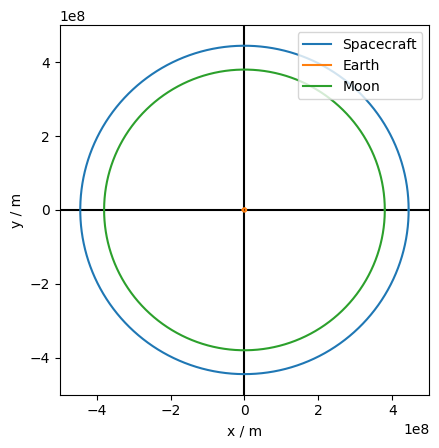

plot limits:(-100000000.0, 100000000.0, -100000000.0, 100000000.0)


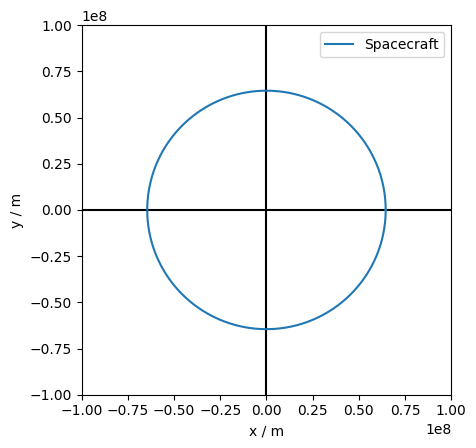

In [34]:

'''FFactor testing
f = 1.04859279325

initialize('constants')
findFFactor(1.04859, 10)
'''


'''limit mode testing
out = RK4ODEsolve3BP('limits', 0, PeriodEM, 100, limits=[l2 - 1e6,l2 + 1e6])

SposList, MposList, EposList, tList = out[0], out[1], out[2], out[3]

print('move = {}'.format(out[4]))
print(out[5])
plot(mode='axes')
plt.xlabel('x / m')
plt.ylabel('y / m')
plot(data=SposList,label='Spacecraft')
plot(data=EposList,label='Earth')
plot(data=MposList,label='Moon')
plot(mode='show')
SLunCoordPos = SposList - MposList
ELunCoordPos = EposList - MposList
plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
plt.xlabel('x / m')
plt.ylabel('y / m')
plot(data=SLunCoordPos, label='Spacecraft')
plot(mode='show')
'''


def full_solve(t_0, t_f, dtTaylor,dtRK4):
    print('   FULL SOLVE')
    print('{:11s}{:10}s   {:9s}{:18.4f}s   {:18s}{:5}s   {:18s}{:5}s'.format('Start time:', t_0, 'End time:', t_f, 'Taylor timestep', dtTaylor,'RK4 timestep',dtRK4))
    global fRK4, fTaylor
    fTaylor = 1.0486073889
    fRK4    = 1.0486156059
    #fRK4    = 1.04859279325 #NOT WORKING

    
    dr = drOriginal *fTaylor
    l2 = rM + dr
    l2vel = 2*np.pi * l2 / PeriodEM


    initialize('constants')
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2vel], startdebugmode='none')
    SposList, MposList, EposList, tList = TaylorODEsolve3BP('solve', t_0, t_f, dtTaylor, progress=False)
    print('l2o: {} m, l2: {} m, dro: {} m, dr: {} m'.format(l2Original, l2,drOriginal, dr))
    plot(mode='axes')
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SposList,label='Spacecraft')
    plot(data=EposList,label='Earth')
    plot(data=MposList,label='Moon')
    plot(mode='show')
    SLunCoordPos = SposList - MposList
    ELunCoordPos = EposList - MposList
    plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SLunCoordPos, label='Spacecraft')
    plot(mode='show')

    #f = 1.04859279325
    f  = 1.0486156059

    dr = drOriginal *fRK4
    l2 = rM + dr
    l2vel = 2*np.pi * l2 / PeriodEM

    initialize('constants')
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2vel], startdebugmode='none')

    SposList, MposList, EposList, tList = RK4ODEsolve3BP('solve', t_0, t_f, dtRK4, progress=False)
    print('l2o: {} m, l2: {} m, dro: {} m, dr: {} m'.format(l2Original, l2,drOriginal, dr))
    plot(mode='axes')
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SposList,label='Spacecraft')
    plot(data=EposList,label='Earth')
    plot(data=MposList,label='Moon')
    plot(mode='show')
    SLunCoordPos = SposList - MposList
    ELunCoordPos = EposList - MposList
    plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SLunCoordPos, label='Spacecraft')
    plot(mode='show')
    

full_solve(0, PeriodEM, 10, 100)


Plotting zone

lagrange point 2:   = 444246952.6309909              m
Moon-L2 distance:   = 64518712.14287148              m
(444242000.0, 444252000.0, -2000.0, 8000.0)


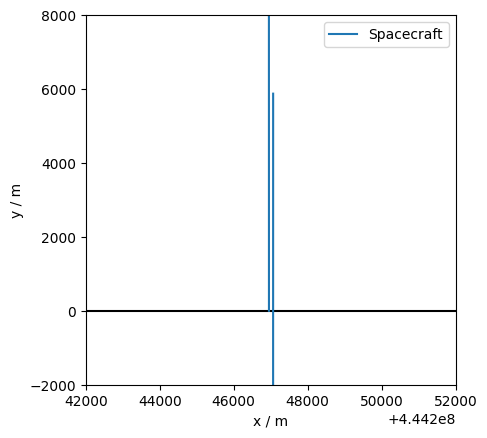

(60000000.0, 70000000.0, -5000000.0, 5000000.0)


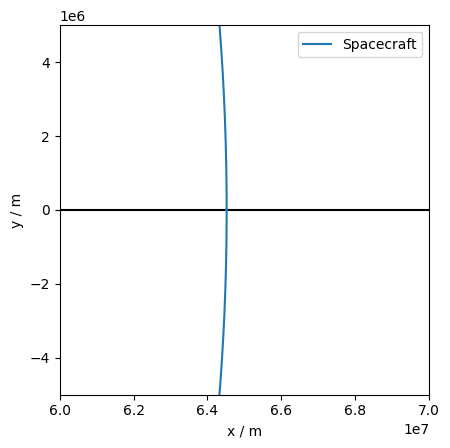

(-50000000.0, 150000000.0, -100000000.0, 100000000.0)


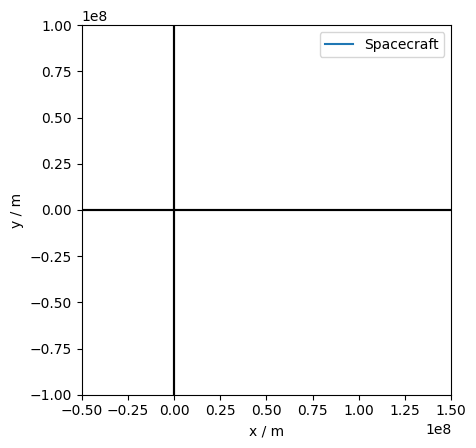

Satellite final position: [4.44247066e+08 5.87520844e+03]
Satellite initial lunar position: [64518712.1428715        0.       ]
Satellite final lunar position: [6.45188256e+07 5.87520844e+03]
64518712.14287148


'\n444248284.96126723\n59848284.96126721\n\n444248254.1968406\n59848254.19684056\n'

In [ ]:
printAlligned('lagrange point 2:', l2, 'm')
printAlligned('Moon-L2 distance:', dr, 'm')

plot(mode='axes',plotLims=[4.44242e8,4.44252e8,-2e3,8e3])
plt.xlabel('x / m')
plt.ylabel('y / m')
plot(data=SposList,label='Spacecraft')
#plot(data=EposList,label='Earth')
#plot(data=MposList,label='Moon')
plot(mode='show')
SLunCoordPos = SposList - MposList
ELunCoordPos = EposList - MposList
plot(mode='axes',plotLims=[6e7, 7e7,-5e6,5e6])
plt.xlabel('x / m')
plt.ylabel('y / m')
plot(data=SLunCoordPos, label='Spacecraft')
plot(mode='show')

SEarCoordPos = SposList - EposList
plot(mode='axes',plotLims=[-5e7, 1.5e8,-1e8,1e8])
plt.xlabel('x / m')
plt.ylabel('y / m')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plot(data=SEarCoordPos, label='Spacecraft')
plot(mode='show')

print('Satellite final position: {}'.format(np.transpose(Spos)))
print('Satellite initial lunar position: {}'.format(np.transpose(SLunCoordPos)[0]))
print('Satellite final lunar position: {}'.format(np.transpose(SLunCoordPos)[-1]))
#dr = d*(mM/3/mE)**(1/3) *0.972686
#l2 = d + d*(mM/3/mE)**(1/3) *0.972686

dr = dEM*(mM/3/mE)**(1/3) *f
print(dr)
'''
444248284.96126723
59848284.96126721

444248254.1968406
59848254.19684056
'''

### Orbital Period ###

```v=2pi*r/P
mv^2=GMm/r
4*pi^2*r^2/P^2=GM/r
P^2 = 4*pi^2*r^3/GM
```
### $v =\frac{2 \pi r}{P} $ ###
### $mv^2 = \frac{Gm_Em_M}{d} = \frac{G M_t m_E}{r_E} = \frac{G M_t m_M}{r_M}$ ###
### $mv^2 = \frac{G (m_M + m_E) m_E}{d\frac{m_M}{m_M + m_E}} = \frac{G (m_M + m_E) m_M}{d\frac{m_E}{m_M + m_E}}$ ###
### $mv^2 = \frac{G (m_M + m_E)^2 m_E}{dm_M} = \frac{G (m_M + m_E)^2 m_M}{dm_E}$ ###
### $\frac{4 \pi^2 r^2}{P^2}=\frac{GM}{r}$ ###
### $P^2 = \frac{4 \pi^2 r^3}{G M}$ ###
### Let, $r = d$, and, $M = M_t = M_e + M_m$. ###
### $P = \sqrt{\frac{4 \pi^2 d^3}{G M_t}}$ ###

Check Y&F central foces

In [ ]:
a = 2357285.970587522
b = timedelta(seconds = a)
print(b)

Me = 5.9742e24
Mm = 7.35e22
Mt = Me + Mm
Re = dEM*Mm/Mt
Rm = dEM*Me/Mt
GravConst = 6.6726e-11
dEM = 3.844e8

PeriodEM = np.sqrt(4 * np.pi**2 * dEM**3 / GravConst / Mt)
print(timedelta(seconds = PeriodEM))
PeriodEM = np.sqrt(4 * np.pi**2 * dEM**3 / GravConst / Me)
print(timedelta(seconds = PeriodEM))
PeriodEM = np.sqrt(4 * np.pi**2 * dEM**3 / GravConst / Mm)
print(timedelta(seconds = PeriodEM))

'''
test = np.zeros((10,2))
t = np.linspace(1,10,10)
test = [[np.sin(t[i]),np.cos(t[i])] for i in range(10)]
test[2] = [2,2]
print(test)
ax = plt.figure().add_subplot()
test = np.transpose(test)
print("\n")
print(np.shape(test))
print(test)
print(test[1])
ax.plot(*test)
'''
'''
def test1():
    N = 10000
    for i in range(N):
        if i % round(N/10) == 0:
            print(i/N)
            n = round(i/N, 2)
            print(n)
test1()
print(round(277.1223, 3))
'''

Simpson's Rule\
Taylor expansion\
Runge-Kutta

### TBP Calc ###
### $\frac{d^2x}{dt^2} = -G m_E \frac{(x - x_E)}{d_E^3} - G m_M \frac{(x - x_M)}{d_M^3}$ ###
### $\frac{d^2y}{dt^2} = -G m_E \frac{(y - y_E)}{d_E^3} - G m_M \frac{(y - y_M)}{d_M^3}$ ###

In [ ]:
initialize('constants')
out = findFFactor('RK4',1 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fRK4 = out[0]
initialize('constants')
out = findFFactor('RK4',local_fRK4, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fRK4)

guess: False
move:      1  steps:           347
move:     -1  steps:           108  f:    1.000000000000  n:                 2
move:      1  steps:           347
move:     -1  steps:           355  f:    1.000000000000  n:                 4
move:      1  steps:           347
move:      1  steps:           391
move:      1  steps:           457
move:      1  steps:           569
move:      1  steps:           838
move:     -1  steps:          2031  f:    1.040000000000  n:                10
move:      1  steps:           838
move:      1  steps:           891
move:      1  steps:           955
move:      1  steps:          1036
move:      1  steps:          1140
move:      1  steps:          1285
move:      1  steps:          1502
move:      1  steps:          1887
move:      1  steps:          2906
move:     -1  steps:          3529  f:    1.048000000000  n:                20
move:      1  steps:          2906
move:      1  steps:          3131
move:      1  steps:          3418
move: 

guess: True
move:      1  steps:         30056
move:     -1  steps:         31978  f:    1.048615605900  n:                 2
f=1.0486156059 in 3 steps
guess: True
error vector:   [  -2406.80340028 -100288.67613927] m
error distance: 100317.55212511552 m
move:      0  steps:         23572  f:    1.048615605900  n:                 1
error vector:   [  -2406.80340028 -100288.67613927] m
error distance: 100317.55212511552 m
f=1.0486156059 in 1 steps
True
[array([[ 4.44248356e+08,  4.44248340e+08,  4.44248293e+08, ...,
         4.44245836e+08,  4.44245908e+08,  4.44245949e+08],
       [ 0.00000000e+00,  1.18411374e+05,  2.36822740e+05, ...,
        -3.37111857e+05, -2.18700274e+05, -1.00288676e+05]]), array([[ 3.79728240e+08,  3.79728227e+08,  3.79728187e+08, ...,
         3.79728130e+08,  3.79728194e+08,  3.79728231e+08],
       [ 0.00000000e+00,  1.01213977e+05,  2.02427946e+05, ...,
        -2.89442179e+05, -1.88228222e+05, -8.70142507e+04]]), array([[-4.67175951e+06, -4.67175935e+06, -

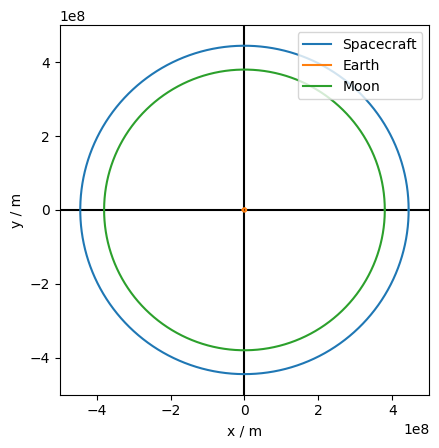

(-100000000.0, 100000000.0, -100000000.0, 100000000.0)


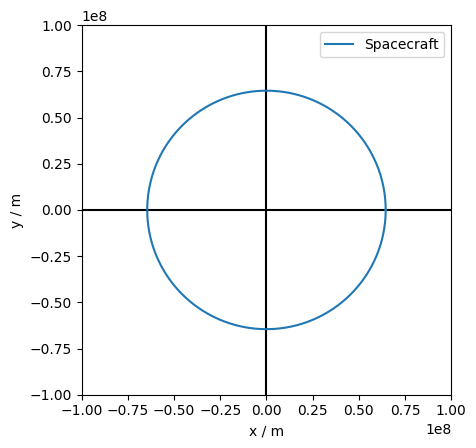

guess: True
move:      1  steps:        305930
move:     -1  steps:        309543  f:    1.048607388900  n:                 2
f=1.0486073889 in 3 steps
guess: True
error vector:   [ -549.3580808  -4364.47395163] m
error distance: 4398.912044520941 m
move:      0  steps:        235728  f:    1.048607388900  n:                 1
f=1.0486073889 in 1 steps
True


In [ ]:
#fRK4    = 1.04859279325

fRK4    = 1.0486156059
fTaylor = 1.0486073889

initialize('constants')
out = findFFactor('RK4',fRK4 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fRK4 = out[0]
initialize('constants')
out = findFFactor('RK4',fRK4, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fRK4)


'''
#print(out[3])
SposList, MposList, EposList, tList = out[3]
plot(mode='axes')
plt.xlabel('x / m')
plt.ylabel('y / m')
plot(data=SposList,label='Spacecraft')
plot(data=EposList,label='Earth')
plot(data=MposList,label='Moon')
plot(mode='show')
SLunCoordPos = SposList - MposList
ELunCoordPos = EposList - MposList
plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
plt.xlabel('x / m')
plt.ylabel('y / m')
plot(data=SLunCoordPos, label='Spacecraft')
plot(mode='show')
'''

initialize('constants')
out = findFFactor('Taylor',fTaylor , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fTaylor = out[0]
initialize('constants')
out = findFFactor('Taylor',fTaylor, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fTaylor)


In [ ]:
print(local_fRK4)
print(local_fTaylor)

1.04859279325
1.0486073889


## Example problem: 1st order ODE ##
$\frac{dN}{dt}=\frac{-N}{\tau}$\
$\ln|N|=\frac{-t}{\tau} + c$\
$N=N_0e^{-\frac{t}{\tau}}$\
Solve using Euler's method and RK4

In [ ]:
def EulerODEsolveN(N_0, tau, t_0, t_f, dt):
    
    steps = int((t_f - t_0) / dt)
    x = np.linspace(t_0, t_f,steps+1)
    y = np.zeros(steps + 1)
    ana = 100 * np.exp(- (x) / tau)
    def d_tN(N):
        derivative = - N / tau
        return derivative
    N = N_0
    t = t_0
    x[0] = t
    y[0] = N
    for i in range(steps):
        N = N + dt * d_tN(N)
        t = t + dt
        x[i+1] = t
        y[i+1] = N
    plt.figure(0)
    plt.plot(x, y)
    plt.plot(x, ana)
    plt.figure(1)
    plt.plot(x,y-ana)
    out = plt.show
    return out
EulerODEsolveN(100, 5, 0, 20, 1e-2)

In [ ]:
def RK4ODEsolveN(N_0, tau, t_0, t_f, dt):
    steps = int((t_f - t_0) / dt)
    x = np.linspace(t_0, t_f,steps+1)
    y = np.zeros(steps + 1)
    ana = 100 * np.exp(- (x) / tau)
    def d_tN(N):
        derivative = - N / tau
        return derivative
    N = N_0
    t = t_0
    x[0] = t
    y[0] = N
    for i in range(steps):
        k1 = d_tN(N)
        k2 = d_tN(N + k1 * dt/2)
        k3 = d_tN(N + k2 * dt/2)
        k4 = d_tN(N + k3 * dt)
        N = N + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt
        x[i+1] = t
        y[i+1] = N
    plt.figure(0)
    plt.plot(x, y)
    plt.plot(x, ana)
    plt.figure(1)
    plt.plot(x,y-ana)
    out = plt.show
    return out
RK4ODEsolveN(100, 5, 0, 20, 1e-2)


4671759.51188055


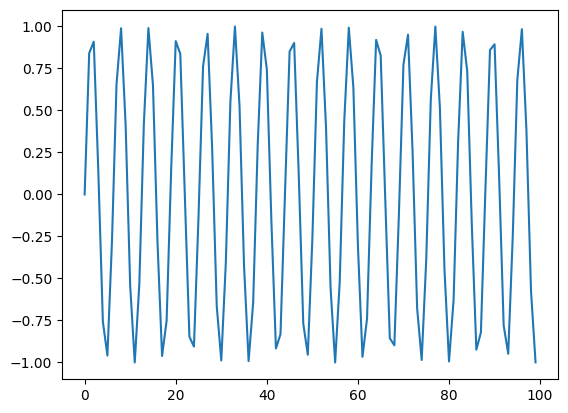

In [ ]:
import math
import cmath
x = np.arange(0,100)
y = np.sin(x)
plt.plot(x,y)
print(rE)


In [ ]:
print(f)

print(fTaylor)

1.04859279325
1.0486073889
